# 1. Imports & inputs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from geopy.geocoders import Nominatim
from kgcpy import lookupCZ
import matplotlib.patches as mpatches
from solcore import material

# define the path to the data folder
ResultsFolder = r'C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results'

# define the path to the site summary file
site_summary_path = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\25_05_01_Newsites_summary.xlsx"

# define the path to the file to add climate zone data
site_summary_path_to_add = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_01_Results\25_05_07_old_and_new_summary.xlsx"

# define the original data folder path
original_data_folder = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data"

# define the plot template
axis_label_size = 20
axis_num_size = 20
text_size = 20
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)
two_by_two_figsize = (12, 12)

# 2. Plot I0/ni2

## 2.1. Find the list of site and seasons

In [2]:
# create an empty list to store the site_id and season
site_ids = []
seasons = []
# read from the Results folder
for folder in os.listdir(ResultsFolder):
    # check if the folder is a folder rather than a file
    if not os.path.isdir(os.path.join(ResultsFolder, folder)):
        continue
    else:
        site_id = folder.split('_')[0]  # assuming site_id is the first part of the folder name
        season = folder.split('_')[1]  # assuming season is the second part of the folder name
        site_ids.append(site_id)
        seasons.append(season)

# remove duplicates
site_ids = list(set(site_ids))
seasons = list(set(seasons))

# print the site_ids and seasons
print(f"Site IDs: {site_ids}")
print(f"Seasons: {seasons}")

Site IDs: ['4093266', '4186157', '4111492', '3455043', '4111800', '4153809', '4173851', '4118327', '4112053', '4184502', '4140175', '4073264', '4111846', '4123602', '4197100', '4034376', '4093272', '4002138', '4122216', '4172746', '4162787']
Seasons: ['winter', 'spring', 'summer', 'autumn']


## 2.2. Plotting

In [3]:
# for site_id in site_ids:
#     for season in seasons:

#         # read the original data folder look for the folder that contains the site id
#         site_folder = None
#         for name in os.listdir(original_data_folder):
#             path = os.path.join(original_data_folder, name)
#             if not os.path.isdir(path):
#                 continue
#             if site_id in name:
#                 site_folder = path
#                 print(f"Found site folder: {site_folder}")

#                 # for each folder in the site folder, read the excel file that contains the word 'optimizer'
#                 # create a list of dataframes to store the optimizer data
#                 # create a list of dataframes to store the optimizer data
#                 optimizer_dfs = []
#                 for subfolder in os.listdir(site_folder):
#                     subfolder_path = os.path.join(site_folder, subfolder)
#                     if not os.path.isdir(subfolder_path):
#                         continue
#                     for file in os.listdir(subfolder_path):
#                         if 'optimizer' in file.lower() and file.endswith('.csv'):
#                             optimizer_file = os.path.join(subfolder_path, file)
#                             print(f"Found optimizer file: {optimizer_file}")
#                             # read the optimizer file
#                             optimizer_df = pd.read_csv(optimizer_file)
#                             # store the optimizer dataframe in the defined list
#                             optimizer_dfs.append(optimizer_df)
#                 # merge all the optimizer dataframes into one dataframe
#                 if optimizer_dfs:
#                     optimizer_df = pd.concat(optimizer_dfs, ignore_index=True)
#                     print(f"Merged optimizer dataframe shape: {optimizer_df.shape}")
#                 else:
#                     print("No optimizer files found.")

#                 # rename the Unamed: 0 column to Timestamp and set it as index
#                 if 'Unnamed: 0' in optimizer_df.columns:
#                     optimizer_df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
#                     optimizer_df.set_index('Timestamp', inplace=True)

#                 # extract Temprature
#                 T_df = optimizer_df[['reporter_id', 'temperature']]
#                 T_df_pivot = T_df.pivot(columns='reporter_id', values='temperature')
#                 T_df_pivot.columns = [f"temperature for reporter id {col}" for col in T_df_pivot.columns]

#        # Find the folder
#         target_folder = None
#         for name in os.listdir(ResultsFolder):
#             path = os.path.join(ResultsFolder, name)
#             if not os.path.isdir(path):
#                 continue
#             if site_id in name and season in name.lower():
#                 target_folder = path
#                 print(f"Found target folder: {target_folder}")
#                 break
#         if target_folder is not None:
#             # read the moutlier label file, which is the file whose name contains the word outlier and is a csv file
#             outlier_file = None
#             for file in os.listdir(target_folder):
#                 if 'outlier' in file.lower() and file.endswith('.csv'):
#                     outlier_file = os.path.join(target_folder, file)
#                     print(f"Found outlier file: {outlier_file}")
#                     # read the outlier file
#                     outlier_df = pd.read_csv(outlier_file)
#                     break
#             if outlier_df is not None:
#                 # merge the temperature dataframe with the outlier dataframe with the Timestamp as index
#                 outlier_df.set_index('Timestamp', inplace=True)
#                 merged_df = pd.merge(outlier_df, T_df_pivot, left_index=True, right_index=True, how='left')
                
#                 # find the I0 columns in the merged dataframe
#                 I0_columns = [col for col in merged_df.columns if 'I0' in col]
#                 for I0_col in I0_columns:
#                     # extract the reporter id from the I0 column name
#                     reporter_id = I0_col.split('_')[-1]
#                     # find the corresponding temperature column
#                     temp_col = f"temperature for reporter id {reporter_id}"

#                     # 1) get temperature in K
#                     temp_K = merged_df[temp_col] + 273.15

#                     # 2) compute ni one-by-one with Solcore
#                     ni_vals = [
#                         material("Si")(T=T_val).ni / 1e6
#                         for T_val in temp_K
#                     ]

#                     # 3) assign back to the DataFrame
#                     merged_df[f"ni_reporter_{reporter_id}"] = ni_vals

#                     # 4) calculate I0/ni2 for the reporter
#                     merged_df[f"I0/ni2_reporter_{reporter_id}"] = merged_df[I0_col] / (merged_df[f"ni_reporter_{reporter_id}"] ** 2)
#                     # ensure the index is a datetime index
#                     # merged_df.index = pd.to_datetime(merged_df.index)
#                     # # replace any value outside 10am and 4pm with NaN
#                     # merged_df[f"I0/ni2_reporter_{reporter_id}"] = merged_df[f"I0/ni2_reporter_{reporter_id}"].where(
#                     #     (merged_df.index.hour >= 10) & (merged_df.index.hour <= 16), np.nan
#                     # )

#                     # 5) plot the I0/ni2 for the reporter
#                     plt.figure(figsize=figure_size)
#                     plt.plot(merged_df.index, merged_df[f"I0/ni2_reporter_{reporter_id}"], label=f"Reporter {reporter_id}")
#                     plt.xlabel('Timestamp', fontsize=axis_label_size)
#                     plt.ylabel('I0/ni^2', fontsize=axis_label_size)
#                     # only show the site id and season in the title
#                     plt.title(f"{site_id} - {season} - Reporter {reporter_id}", fontsize=title_size)
#                     plt.legend(fontsize=text_size)
#                     plt.tight_layout()
#                     plt.xticks([])
#                     # update the xticks size
#                     plt.tick_params(axis='x', labelsize=axis_num_size)
#                     # update the ytick size
#                     plt.tick_params(axis='y', labelsize=axis_num_size)
#                     # plt.yscale('log')
#                     # save the figure
#                     plt.savefig(os.path.join(target_folder, f"{site_id}_{season}_I0_ni2_reporter_{reporter_id}.png"))
#                     plt.show()

#                     # remove the index where there is any nan from the df
#                     # merged_df = merged_df.dropna(subset=[f"I0/ni2_reporter_{reporter_id}"])

#                     # plot the ni^2 and I0 for the reporter
#                     plt.figure(figsize=figure_size)
#                     ax1 = plt.gca()
#                     ax1.plot(merged_df.index, merged_df[f"ni_reporter_{reporter_id}"] ** 2, label=f"ni^2 for Reporter {reporter_id}", color='tab:blue')
#                     ax1.set_xlabel('Timestamp', fontsize=axis_label_size)
#                     ax1.set_ylabel('ni^2', fontsize=axis_label_size, color='tab:blue')
#                     ax1.tick_params(axis='y', labelcolor='tab:blue')
#                     # change to log scale
#                     # ax1.set_yscale('log')
#                     # updateh the y tick size
#                     plt.tick_params(axis='y', labelsize=axis_num_size)
#                     plt.title(f"{site_id} - {season} - Reporter {reporter_id}", fontsize=title_size)
#                     plt.xticks([])

#                     # Create a secondary y-axis for I0
#                     ax2 = ax1.twinx()
#                     ax2.plot(merged_df.index, merged_df[I0_col], label=f"I0 for Reporter {reporter_id}", linestyle='--', color='tab:orange')
#                     ax2.set_ylabel('I0', fontsize=axis_label_size, color='tab:orange')
#                     ax2.tick_params(axis='y', labelcolor='tab:orange')
#                     # change to log scale
#                     # ax2.set_yscale('log')

#                     fig = plt.gcf()
#                     fig.tight_layout()
#                     # update the x and y ticks size
#                     plt.tick_params(axis='x', labelsize=axis_num_size)
#                     plt.tick_params(axis='y', labelsize=axis_num_size)
#                     # save the figure
#                     plt.savefig(os.path.join(target_folder, f"{site_id}_{season}_ni2_I0_reporter_{reporter_id}.png"))
#                     # plt.legend(loc='upper left', fontsize=text_size)
#                     plt.show()

#                     # plot I0 only
#                     plt.figure(figsize=figure_size)
#                     plt.plot(merged_df.index, merged_df[I0_col], label=f"I0 for Reporter {reporter_id}", color='tab:orange')
#                     plt.xlabel('Timestamp', fontsize=axis_label_size)
#                     plt.ylabel('I0', fontsize=axis_label_size)
#                     plt.title(f"{site_id} - {season} - Reporter {reporter_id}", fontsize=title_size)
#                     plt.xticks([])
#                     plt.tick_params(axis='x', labelsize=axis_num_size)
#                     plt.tick_params(axis='y', labelsize=axis_num_size)
#                     plt.tight_layout()
#                     plt.savefig(os.path.join(target_folder, f"{site_id}_{season}_I0_reporter_{reporter_id}.png"))
#                     plt.show()

Found site folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\4034376
Found optimizer file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\4034376\december\optimizer_data.csv
Found optimizer file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\4034376\june\optimizer_data.csv
Found optimizer file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\4034376\march\optimizer_data.csv
Found optimizer file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Data\4034376\september\optimizer_data.csv
Merged optimizer dataframe shape: (82567, 10)
Found target folder: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_winter_20250519_105712
Found outlier file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\24_09_24_Solar_Edge\Results\v_from_i_combined\25_05_19_Results\4034376_winter_202505

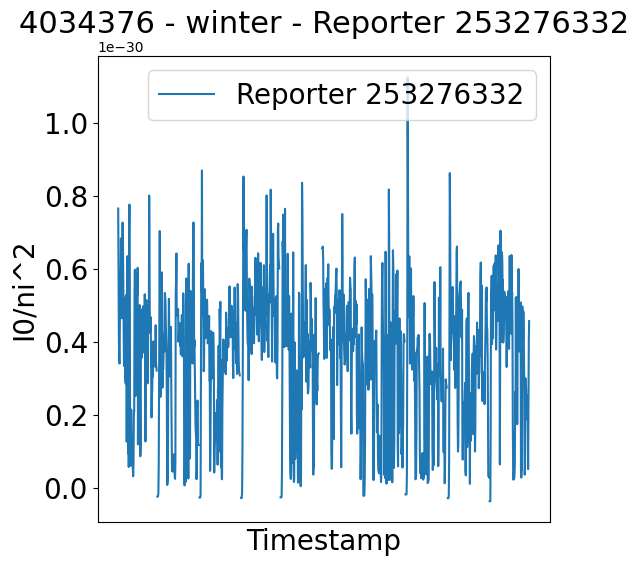

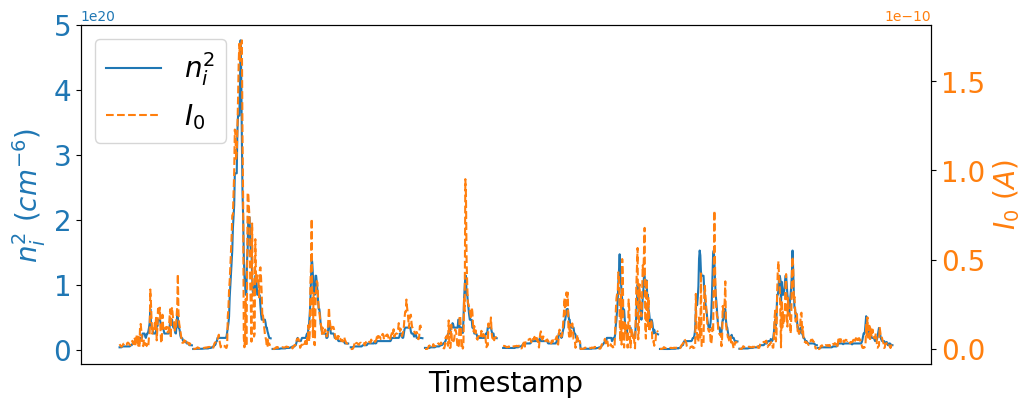

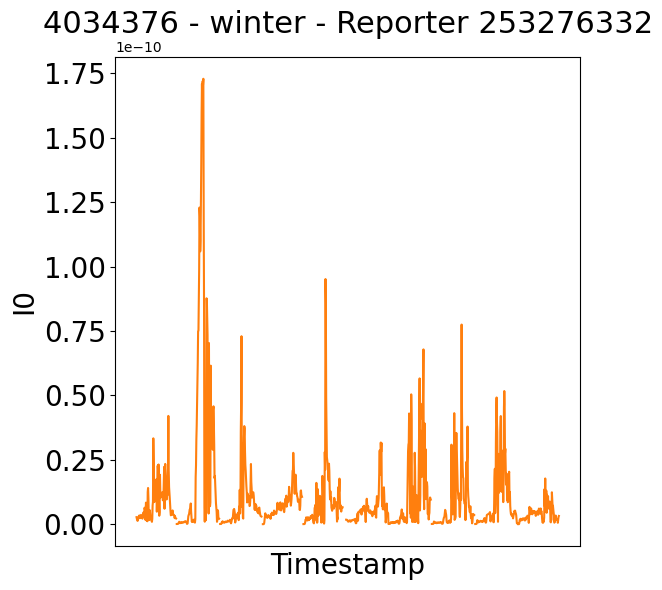

In [7]:
# Define the specific site, season, and reporter you want to process
site_id_target = '4034376'
season_target = 'winter'
reporter_id_target = '253276332'

# Loop only through the specified site and season
for site_id in [site_id_target]:
    for season in [season_target]:

        # read the original data folder look for the folder that contains the site id
        site_folder = None
        for name in os.listdir(original_data_folder):
            path = os.path.join(original_data_folder, name)
            if not os.path.isdir(path):
                continue
            if site_id in name:
                site_folder = path
                print(f"Found site folder: {site_folder}")

                # for each folder in the site folder, read the excel file that contains the word 'optimizer'
                # create a list of dataframes to store the optimizer data
                optimizer_dfs = []
                for subfolder in os.listdir(site_folder):
                    subfolder_path = os.path.join(site_folder, subfolder)
                    if not os.path.isdir(subfolder_path):
                        continue
                    for file in os.listdir(subfolder_path):
                        if 'optimizer' in file.lower() and file.endswith('.csv'):
                            optimizer_file = os.path.join(subfolder_path, file)
                            print(f"Found optimizer file: {optimizer_file}")
                            # read the optimizer file
                            optimizer_df = pd.read_csv(optimizer_file)
                            # store the optimizer dataframe in the defined list
                            optimizer_dfs.append(optimizer_df)
                # merge all the optimizer dataframes into one dataframe
                if optimizer_dfs:
                    optimizer_df = pd.concat(optimizer_dfs, ignore_index=True)
                    print(f"Merged optimizer dataframe shape: {optimizer_df.shape}")
                else:
                    print("No optimizer files found.")

                # rename the Unamed: 0 column to Timestamp and set it as index
                if 'Unnamed: 0' in optimizer_df.columns:
                    optimizer_df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
                    optimizer_df.set_index('Timestamp', inplace=True)

                # extract Temprature
                T_df = optimizer_df[['reporter_id', 'temperature']]
                T_df_pivot = T_df.pivot(columns='reporter_id', values='temperature')
                T_df_pivot.columns = [f"temperature for reporter id {col}" for col in T_df_pivot.columns]

       # Find the folder
        target_folder = None
        for name in os.listdir(ResultsFolder):
            path = os.path.join(ResultsFolder, name)
            if not os.path.isdir(path):
                continue
            if site_id in name and season in name.lower():
                target_folder = path
                print(f"Found target folder: {target_folder}")
                break
        if target_folder is not None:
            # read the moutlier label file, which is the file whose name contains the word outlier and is a csv file
            outlier_file = None
            for file in os.listdir(target_folder):
                if 'outlier' in file.lower() and file.endswith('.csv'):
                    outlier_file = os.path.join(target_folder, file)
                    print(f"Found outlier file: {outlier_file}")
                    # read the outlier file
                    outlier_df = pd.read_csv(outlier_file)
                    break
            if outlier_df is not None:
                # merge the temperature dataframe with the outlier dataframe with the Timestamp as index
                outlier_df.set_index('Timestamp', inplace=True)
                merged_df = pd.merge(outlier_df, T_df_pivot, left_index=True, right_index=True, how='left')
                
                # find the I0 columns in the merged dataframe
                I0_columns = [col for col in merged_df.columns if 'I0' in col]
                for I0_col in I0_columns:
                    # extract the reporter id from the I0 column name
                    reporter_id = I0_col.split('_')[-1]
                    
                    # Add a condition to only process the target reporter
                    if reporter_id != reporter_id_target:
                        continue
                        
                    # find the corresponding temperature column
                    temp_col = f"temperature for reporter id {reporter_id}"

                    # 1) get temperature in K
                    temp_K = merged_df[temp_col] + 273.15

                    # 2) compute ni one-by-one with Solcore
                    ni_vals = [
                        material("Si")(T=T_val).ni / 1e6
                        for T_val in temp_K
                    ]

                    # 3) assign back to the DataFrame
                    merged_df[f"ni_reporter_{reporter_id}"] = ni_vals

                    # 4) calculate I0/ni2 for the reporter
                    merged_df[f"I0/ni2_reporter_{reporter_id}"] = merged_df[I0_col] / (merged_df[f"ni_reporter_{reporter_id}"] ** 2)
                    # ensure the index is a datetime index
                    # merged_df.index = pd.to_datetime(merged_df.index)
                    # # replace any value outside 10am and 4pm with NaN
                    # merged_df[f"I0/ni2_reporter_{reporter_id}"] = merged_df[f"I0/ni2_reporter_{reporter_id}"].where(
                    #     (merged_df.index.hour >= 10) & (merged_df.index.hour <= 16), np.nan
                    # )

                    # 5) plot the I0/ni2 for the reporter
                    plt.figure(figsize=figure_size)
                    plt.plot(merged_df.index, merged_df[f"I0/ni2_reporter_{reporter_id}"], label=f"Reporter {reporter_id}")
                    plt.xlabel('Timestamp', fontsize=axis_label_size)
                    plt.ylabel('I0/ni^2', fontsize=axis_label_size)
                    # only show the site id and season in the title
                    plt.title(f"{site_id} - {season} - Reporter {reporter_id}", fontsize=title_size)
                    plt.legend(fontsize=text_size)
                    plt.tight_layout()
                    plt.xticks([])
                    # update the xticks size
                    plt.tick_params(axis='x', labelsize=axis_num_size)
                    # update the ytick size
                    plt.tick_params(axis='y', labelsize=axis_num_size)
                    # plt.yscale('log')
                    # save the figure
                    plt.savefig(os.path.join(target_folder, f"{site_id}_{season}_I0_ni2_reporter_{reporter_id}.png"))
                    plt.show()

                    # remove the index where there is any nan from the df
                    # merged_df = merged_df.dropna(subset=[f"I0/ni2_reporter_{reporter_id}"])
                    # plot the ni^2 and I0 for the reporter
                    fig, ax1 = plt.subplots(figsize=long_hoz_figsize)

                    # Plot ni^2 on the primary y-axis
                    line1 = ax1.plot(merged_df.index, merged_df[f"ni_reporter_{reporter_id}"] ** 2, label=r'$n_i^2$', color='tab:blue')
                    ax1.set_xlabel('Timestamp', fontsize=axis_label_size)
                    ax1.set_ylabel(r'$n_i^2 \ (cm^{-6})$', fontsize=axis_label_size, color='tab:blue')
                    ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=axis_num_size)
                    ax1.tick_params(axis='x', labelsize=axis_num_size)
                    
                    # Create a secondary y-axis for I0
                    ax2 = ax1.twinx()
                    line2 = ax2.plot(merged_df.index, merged_df[I0_col], label=r'$I_0$', linestyle='--', color='tab:orange')
                    ax2.set_ylabel(r'$I_0 \ (A)$', fontsize=axis_label_size, color='tab:orange')
                    ax2.tick_params(axis='y', labelcolor='tab:orange', labelsize=axis_num_size)

                    # Title and legend
                    # plt.title(f"{site_id} - {season} - Reporter {reporter_id}", fontsize=title_size)
                    lines = line1 + line2
                    labels = [l.get_label() for l in lines]
                    ax1.legend(lines, labels, loc='upper left', fontsize=text_size)

                    # Format x-axis date ticks
                    fig.autofmt_xdate()
                    plt.tight_layout()
                    ax1.set_xticks([])  # Hide x-ticks
                    
                    # save the figure
                    # plt.savefig(os.path.join(target_folder, f"{site_id}_{season}_ni2_I0_reporter_{reporter_id}.png"))
                    plt.show()

                    # plot I0 only
                    plt.figure(figsize=figure_size)
                    plt.plot(merged_df.index, merged_df[I0_col], label=f"I0 for Reporter {reporter_id}", color='tab:orange')
                    plt.xlabel('Timestamp', fontsize=axis_label_size)
                    plt.ylabel('I0', fontsize=axis_label_size)
                    plt.title(f"{site_id} - {season} - Reporter {reporter_id}", fontsize=title_size)
                    plt.xticks([])
                    plt.tick_params(axis='x', labelsize=axis_num_size)
                    plt.tick_params(axis='y', labelsize=axis_num_size)
                    plt.tight_layout()
                    plt.show()